# Portfolio returns during the crisis

The first step in quantifying the effects of uncertainty on a financial portfolio is to examine the portfolio's return. We'll consider a portfolio of four investment bank stocks, which were both instigators and victims of the global financial crisis.

In [1]:
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from pandas_datareader import DataReader
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [6.75,6]
import numpy as np

In [2]:
stocklist = ['C', 'MS', 'GS', 'JPM']

start = datetime(2004,12,31)
end = datetime(2010,12,31)

portfolio = DataReader(stocklist, 'yahoo',start, end)['Close']
portfolio.rename(columns={'C':'Citibank', 'MS':'Morgan Stanley','GS':'Goldman Sachs','JPM':'J.P. Morgan'}, inplace=True)
portfolio.head()

weights = [0.25, 0.25, 0.25, 0.25]

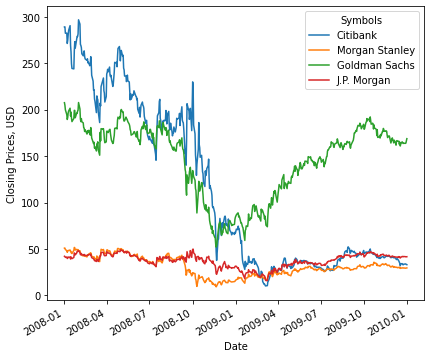

In [3]:
# Select portfolio asset prices for the middle of the crisis, 2008-2009
asset_prices = portfolio.loc['2008-01-01':'2009-12-31']

# Plot portfolio's asset prices during this time
asset_prices.plot().set_ylabel('Closing Prices, USD')
plt.show()

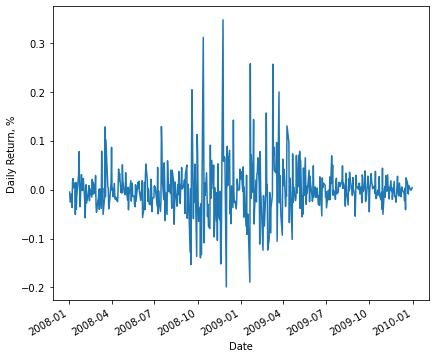

In [4]:
# Compute the portfolio's daily returns
asset_returns = asset_prices.pct_change()
portfolio_returns = asset_returns.dot(weights)

# Plot portfolio returns
portfolio_returns.plot().set_ylabel('Daily Return, %')
plt.show()

## Asset covariance and portfolio volatility

The asset prices plot shows how the global financial crisis created a loss in confidence in investment banks from September 2008. There was an event during September that precipitated this decline, and we'll examine this shortly. The 'spikiness' of portfolio returns indicates how uncertain and volatile asset returns became. We'll quantify this volatility now.

In [5]:
# Generate the covariance matrix from portfolio asset's returns
covariance = asset_returns.cov()

# Annualize the covariance using 252 trading days per year
covariance = covariance * 252

# Display the covariance matrix
print(covariance)

Symbols         Citibank  Morgan Stanley  Goldman Sachs  J.P. Morgan
Symbols                                                             
Citibank        1.475195        0.821707       0.573790     0.724639
Morgan Stanley  0.821707        1.298341       0.658895     0.560523
Goldman Sachs   0.573790        0.658895       0.500807     0.426979
J.P. Morgan     0.724639        0.560523       0.426979     0.685584


In [6]:
# Compute and display portfolio volatility for 2008 - 2009
portfolio_variance = np.transpose(weights) @ covariance @ weights
portfolio_volatility = np.sqrt(portfolio_variance)
print(portfolio_volatility)

0.8475328486592077


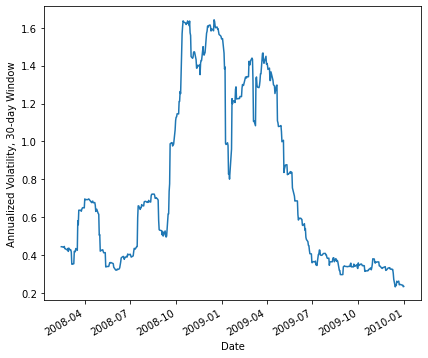

In [7]:
# Calculate the 30-day rolling window of portfolio returns
returns_windowed = portfolio_returns.rolling(30)

# Compute the annualized volatility series
volatility_series = returns_windowed.std()*np.sqrt(252)

# Plot the portfolio volatility
volatility_series.plot().set_ylabel('Annualized Volatility, 30-day Window')
plt.show()

Citibank exhibited the highest volatility during the crisis period, with Morgan Stanley not far behind. The volatility plot shows that an equal-weighted portfolio of all four banks demonstrated a significant increase in volatility from late September 2008, which is around the time the 4th-largest investment bank in the world, Lehman Brothers, went bankrupt. Its bankruptcy was largely due to mismanagement of the risks associated with its holdings of mortgage-backed securities.

## Frequency resampling primer

Risk factor models often rely upon data that is of different frequencies. A typical example is when using quarterly macroeconomic data, such as prices, unemployment rates, etc., with financial data, which is often daily (or even intra-daily). To use both data sources in the same model, higher frequency data needs to be resampled to match the lower frequency data.

In [8]:
# Compute the portfolio's daily returns since 2005
asset_returns = portfolio.pct_change()
portfolio_returns = asset_returns.dot(weights)

# Convert daily returns to quarterly average returns
returns_q = portfolio_returns.resample('Q').mean()

# Examine the beginning of the quarterly series
print(returns_q.head())

# Now convert daily returns to weekly minimum returns
returns_w = portfolio_returns.resample('W').min()

# Examine the beginning of the weekly series
print(returns_w.head())

# Compute the portfolio's daily volatility since 2005
volatility_d = portfolio_returns.expanding(2).std()

# Examine the beginning of the quarterly series
print(volatility_d.head())

Date
2004-12-31         NaN
2005-03-31   -0.000367
2005-06-30   -0.000366
2005-09-30    0.000615
2005-12-31    0.001323
Freq: Q-DEC, dtype: float64
Date
2005-01-02         NaN
2005-01-09   -0.011152
2005-01-16   -0.007643
2005-01-23   -0.011076
2005-01-30   -0.000443
Freq: W-SUN, dtype: float64
Date
2004-12-31         NaN
2005-01-03         NaN
2005-01-04    0.011607
2005-01-05    0.008530
2005-01-06    0.010166
dtype: float64


## Visualizing risk factor correlation

Investment banks heavily invested in mortgage-backed securities (MBS) before and during the financial crisis. This makes MBS a likely risk factor for the investment bank portfolio. We'll assess this using scatterplots between portfolio returns and an MBS risk measure, the 90-day mortgage delinquency rate mort_del.

In [9]:
# Read mortgage delinquency rate historical data from FRED https://fred.stlouisfed.org/series/DRSFRMACBS
mort_del = pd.read_csv('~/Desktop/Portfolio/Quantitative Risk Management/datasets/DRSFRMACBS.csv'\
                       , index_col=0)

mort_del.rename(columns={'DRSFRMACBS':'Mortgage Delinquency Rate'}, inplace=True)

mort_del = mort_del.loc['2005-04-01':'2011-01-01']

print(mort_del.head())
print(type(mort_del))

            Mortgage Delinquency Rate
DATE                                 
2005-04-01                       1.55
2005-07-01                       1.59
2005-10-01                       1.63
2006-01-01                       1.61
2006-04-01                       1.62
<class 'pandas.core.frame.DataFrame'>


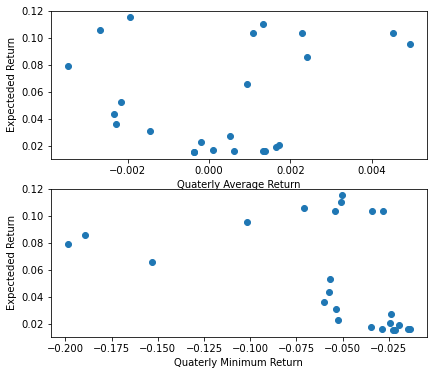

In [10]:
# Transform the daily portfolio_returns into quarterly average returns
portfolio_q_average = portfolio_returns.resample('Q').mean().dropna()

# Transform daily portfolio_returns returns into quarterly minimum returns
portfolio_q_min = portfolio_returns.resample('Q').min().dropna()

# Create a scatterplot between quarterly average and minimum returns and delinquency
fig, axs = plt.subplots(2)
axs[0].scatter(portfolio_q_average, mort_del/100)
axs[0].set_xlabel('Quaterly Average Return')
axs[0].set_ylabel('Expecteded Return')
axs[1].scatter(portfolio_q_min, mort_del/100)
axs[1].set_xlabel('Quaterly Minimum Return')
axs[1].set_ylabel('Expecteded Return')
plt.show()

Our initial assessment indicates that there is little correlation between average returns and mortgage delinquencies, but a stronger negative correlation exists between minimum returns and delinquency. In the following exercises we'll quantify this using least-squares regression.

## Least-squares factor model

There is a negative correlation between minimum quarterly returns and mortgage delinquency rates from 2005 - 2010. This can be made more precise with an OLS regression factor model.

We'll compare three factor models with three different quarterly dependent variables: average returns, minimum returns, and average volatility. The independent variable is the mortgage delinquency rate. In the regression summary, examine the coefficients' t-statistic for statistical significance, as well as the overall R-squared for goodness of fit.

In [11]:
import statsmodels.api as sm

# Align indexes
mort_del = mort_del.set_index(portfolio_q_average.index)

# Add a constant to the regression
mort_del = sm.add_constant(mort_del)

In [12]:
# Create the regression factor model and fit it to the data
results = sm.OLS(portfolio_q_average, mort_del).fit()

# Print a summary of the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                 -0.023
Method:                 Least Squares   F-statistic:                    0.4769
Date:                Fri, 03 Jul 2020   Prob (F-statistic):              0.497
Time:                        16:44:10   Log-Likelihood:                 113.91
No. Observations:                  24   AIC:                            -223.8
Df Residuals:                      22   BIC:                            -221.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [13]:
# Create the regression factor model and fit it to the data
results = sm.OLS(portfolio_q_min, mort_del).fit()

# Print a summary of the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     4.764
Date:                Fri, 03 Jul 2020   Prob (F-statistic):             0.0400
Time:                        16:44:10   Log-Likelihood:                 39.938
No. Observations:                  24   AIC:                            -75.88
Df Residuals:                      22   BIC:                            -73.52
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [14]:
vol_q_mean = volatility_d.resample('Q').mean().dropna()

# Create the regression factor model and fit it to the data
results = sm.OLS(vol_q_mean, mort_del).fit()

# Print a summary of the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     656.8
Date:                Fri, 03 Jul 2020   Prob (F-statistic):           7.08e-18
Time:                        16:44:10   Log-Likelihood:                 114.01
No. Observations:                  24   AIC:                            -224.0
Df Residuals:                      22   BIC:                            -221.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

As seen from the regressions, mortgage delinquencies are acting as a systematic risk factor for both minimum quarterly returns and average volatility of returns, but not for average quarterly returns. The R-squared goodness of fit isn't high in any case, but a model with more factors would likely generate greater explanatory power.

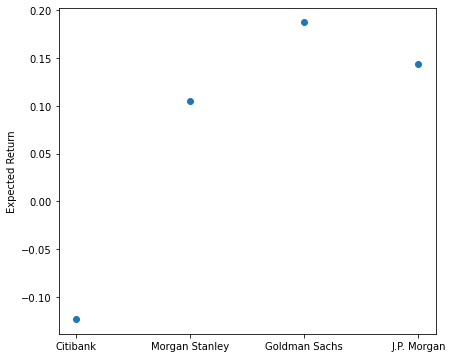

In [15]:
# Import the mean_historical_return method
from pypfopt.expected_returns import mean_historical_return

# Compute the annualized average historical return
mean_returns = mean_historical_return(portfolio, frequency = 252)

# Plot the annualized average historical return
plt.plot(mean_returns, linestyle = 'None', marker = 'o')
plt.ylabel('Expected Return')
plt.show()

The average historical return is usually available as a proxy for expected returns, but is not always accurate--a more thorough estimate of expected returns requires an assumption about the return distribution.

# Practice with PyPortfolioOpt: covariance

Portfolio optimization relies upon an unbiased and efficient estimate of asset covariance. Although sample covariance is unbiased, it is not efficient--extreme events tend to be overweighted.

In [16]:
# Import the CovarianceShrinkage object
from pypfopt.risk_models import CovarianceShrinkage

# Create the CovarianceShrinkage instance variable
cs = CovarianceShrinkage(portfolio)

In [17]:
# Compute the sample covariance matrix of returns
sample_cov = portfolio.pct_change().cov() * 252

# Compute the efficient covariance matrix of returns
e_cov = cs.ledoit_wolf()

# Display both the sample covariance_matrix and the efficient e_cov estimate
print("Sample Covariance Matrix\n\n", sample_cov, "\n\n")
print("Efficient Covariance Matrix\n\n", e_cov, "\n")

Sample Covariance Matrix

 Symbols         Citibank  Morgan Stanley  Goldman Sachs  J.P. Morgan
Symbols                                                             
Citibank        0.535865        0.304847       0.217847     0.269602
Morgan Stanley  0.304847        0.491671       0.258452     0.218162
Goldman Sachs   0.217847        0.258452       0.217542     0.170825
J.P. Morgan     0.269602        0.218162       0.170825     0.264143 


Efficient Covariance Matrix

 Symbols         Citibank  Morgan Stanley  Goldman Sachs  J.P. Morgan
Symbols                                                             
Citibank        0.527162        0.288594       0.206232     0.255228
Morgan Stanley  0.288594        0.485324       0.244673     0.206531
Goldman Sachs   0.206232        0.244673       0.225811     0.161717
J.P. Morgan     0.255228        0.206531       0.161717     0.269926 



Although the differences between the sample covariance and the efficient covariance (found by shrinking errors) may seem small, they have a huge impact on estimation of the optimal portfolio weights and the generation of the efficient frontier. Practitioners generally use some form of efficient covariance for Modern Portfolio Theory.

## Breaking down the financial crisis

For each period we'll compute the efficient covariance matrix, and compare them to each other.

In [18]:
# Create a dictionary of time periods (or 'epochs')
epochs = { 'before' : {'start': '1-1-2005', 'end': '31-12-2006'},
           'during' : {'start': '1-1-2007', 'end': '31-12-2008'},
           'after'  : {'start': '1-1-2009', 'end': '31-12-2010'}
         }

# Compute the efficient covariance for each epoch
expected_returns, e_cov = {}, {}
for x in epochs.keys():
    sub_price = portfolio.loc[epochs[x]['start']:epochs[x]['end']]
    expected_returns[x] = mean_historical_return(sub_price, frequency = 252)
    e_cov[x] = CovarianceShrinkage(sub_price).ledoit_wolf()
    print("\n\t\tEfficient Covariance Matrices - ", x, '\n')
    print(e_cov[x])


		Efficient Covariance Matrices -  before 

Symbols         Citibank  Morgan Stanley  Goldman Sachs  J.P. Morgan
Symbols                                                             
Citibank        0.018149        0.013789       0.013183     0.013523
Morgan Stanley  0.013789        0.043021       0.030559     0.016525
Goldman Sachs   0.013183        0.030559       0.044482     0.018237
J.P. Morgan     0.013523        0.016525       0.018237     0.024182

		Efficient Covariance Matrices -  during 

Symbols         Citibank  Morgan Stanley  Goldman Sachs  J.P. Morgan
Symbols                                                             
Citibank        0.713035        0.465336       0.323977     0.364848
Morgan Stanley  0.465336        0.994390       0.434874     0.298613
Goldman Sachs   0.323977        0.434874       0.408773     0.224668
J.P. Morgan     0.364848        0.298613       0.224668     0.422516

		Efficient Covariance Matrices -  after 

Symbols         Citibank  Morgan Stanl

The breakdown of the 2005 - 2010 period into sub-periods shows how the portfolio's risk increased during the crisis, and this changed the risk-return trade-off after the crisis.

## The efficient frontier and the financial crisis

Previously you examined the covariance matrix of the investment bank portfolio before, during and after the financial crisis. Now you will visualize the changes that took place in the efficient frontier, showing how the crisis created a much higher baseline risk for any given return.

OrderedDict([('Citibank', 0.6576532818916289), ('Morgan Stanley', 0.04800603659827492), ('Goldman Sachs', 0.04037740722024306), ('J.P. Morgan', 0.25396327428985344)])
OrderedDict([('Citibank', 0.0), ('Morgan Stanley', 0.0), ('Goldman Sachs', 0.5179899553131889), ('J.P. Morgan', 0.482010044686811)])
OrderedDict([('Citibank', 0.0), ('Morgan Stanley', 0.034383351654190986), ('Goldman Sachs', 0.8629586772839328), ('J.P. Morgan', 0.10265797106187587)])


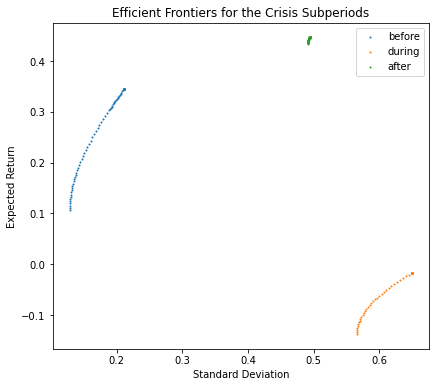

In [19]:
from pypfopt import CLA

plt.title('Efficient Frontiers for the Crisis Subperiods')
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')

for x in epochs.keys():
    # Initialize the Crtical Line Algorithm object
    efficient_portfolio_during = CLA(expected_returns[x], e_cov[x])

    # Find the minimum volatility portfolio weights and display them
    print(efficient_portfolio_during.min_volatility())

    # Compute the efficient frontier
    (ret, vol, weights) = efficient_portfolio_during.efficient_frontier()

    # Add the frontier to the plot showing the 'before' and 'after' frontiers
    plt.scatter(vol, ret, s = 4, marker = '.', label = x)
    plt.legend()